In [0]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import sys

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm

import random
import time
import dill
from collections import defaultdict

from windy_gridworld_env import WindyGridWorldEnv
from windy_gridworld_random_reward_env import WindyGridWorldRandomRewardEnv
from stoch_windy_gridworld_env import StochWindyGridWorldEnv
from stoch_windy_gridworld_random_reward_env import StochWindyGridWorldRandomRewardEnv

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

EPS = float(np.finfo(np.float32).eps)

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

In [0]:
envs = [WindyGridWorldEnv(), WindyGridWorldRandomRewardEnv(), StochWindyGridWorldEnv(), StochWindyGridWorldRandomRewardEnv()]
names = ['windy_gridworld', 'windy_gridworld_r', 'windy_gridworld_s', 'windy_gridworld_s_r']

env = envs[0]

In [0]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    """
    def policy_fn(observation):
        return int(np.random.rand() * nA) if np.random.rand() < epsilon else np.argmax(Q[observation])
    return policy_fn

100%|██████████| 1000/1000 [00:00<00:00, 1244.94it/s]


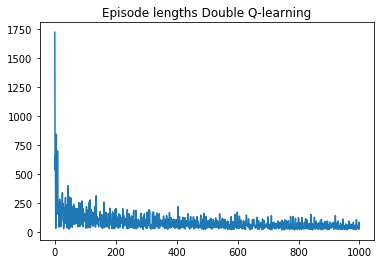

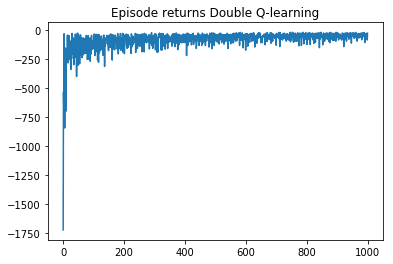

In [0]:
# def avg_Q_vals(env, Q1,Q2):
 
#   Q1_avg_Q2 = defaultdict(lambda: np.zeros(env.action_space.n)) # Needed for policy
#   for key, value in Q1.items():
#         Q1_avg_Q2[key] = (Q1[key] + Q2[key])/2

#   return Q1_avg_Q2

def double_q_learning(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Double Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function
    # A nested dictionary that maps state -> (action -> action-value).
    Q1 = defaultdict(lambda: np.zeros(env.action_space.n))
    n_Q1 = defaultdict(lambda: np.zeros(env.action_space.n) + 1)
    Q2 = defaultdict(lambda: np.zeros(env.action_space.n))
    n_Q2 = defaultdict(lambda: np.zeros(env.action_space.n) + 1)
    Q1_avg_Q2 = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = []
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q1_avg_Q2, epsilon, env.action_space.n)

    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        # YOUR CODE HERE
        s = env.reset()
        done = False
        while not done:
            a = policy(s)
            new_s, r, done, _ = env.step(a)
            R += r
            coin_toss = random.randint(0, 1)
            if (coin_toss == 0):
              alpha = 1 / (n_Q1[s][a]**0.8)
              Q1[s][a] = Q1[s][a] + alpha * (r + discount_factor * Q2[new_s][np.argmax(Q1[new_s])] - Q1[s][a]) if not done else Q1[s][a] + alpha * (r - Q1[s][a])
              n_Q1[s][a] += 1
            else:
              alpha = 1 / (n_Q2[s][a]**0.8)
              Q2[s][a] = Q2[s][a] + alpha * (r + discount_factor * Q1[new_s][np.argmax(Q2[new_s])] - Q2[s][a]) if not done else Q2[s][a] + alpha * (r - Q2[s][a])
              n_Q2[s][a] += 1
            
            #Q1_avg_Q2[s][a] = np.maximum(Q1[s][a], Q2[s][a])
            Q1_avg_Q2[s][a] = (Q1[s][a] + Q2[s][a]) / 2
            s = new_s
            i += 1
        
        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    #return Q1_avg_Q2, (episode_lengths, episode_returns)
    return Q1_avg_Q2, (episode_lengths, episode_returns)

Double_q_learning, (episode_lengths_double_q_learning, episode_returns_double_q_learning) = double_q_learning(env, 1000)

# We will help you with plotting this time
plt.plot(episode_lengths_double_q_learning)
plt.title('Episode lengths Double Q-learning')
plt.show()
plt.plot(episode_returns_double_q_learning)
plt.title('Episode returns Double Q-learning')
plt.show()

In [0]:
def q_learning(env, num_episodes, discount_factor=1.0, epsilon=0.1, Q=None, n_Q=None):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    if Q is None:
        Q = defaultdict(lambda: np.zeros(env.action_space.n))
    if n_Q is None:
        n_Q = defaultdict(lambda: np.zeros(env.action_space.n) + 1)
    
    # Keeps track of useful statistics
    stats = []
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    

    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        # YOUR CODE HERE
        s = env.reset()
        done = False
        while not done:
            a = policy(s)
            new_s, r, done, _ = env.step(a)
                          
            R += r
            alpha = 1 / (n_Q[s][a]**0.8)
            Q[s][a] = Q[s][a] + alpha * (r + discount_factor * np.max(Q[new_s]) - Q[s][a]) if not done else Q[s][a] + alpha * (r - Q[s][a])
            n_Q[s][a] += 1
            s = new_s
            i += 1
        
        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, 1000)

# We will help you with plotting this time
#plt.plot(episode_lengths_q_learning)
#plt.title('Episode lengths Q-learning')
#plt.show()
#plt.plot(episode_returns_q_learning)
#plt.title('Episode returns Q-learning')
#plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 1728.69it/s]


In [0]:
def sample_returns(policy, nr_iter=1):
    rewards = []
    for i in range(nr_iter):
      R = 0
      s = env.reset()
      done = False
      i = 0
      while not done:
          i+=1
          if i > 10000:
            raise Exception("ERROR")
          a = policy(s)
          new_situation = env.step(a)
          R += new_situation[1]
          done = new_situation[2]
          s = new_situation[0]
      rewards.append(R)
    return i, np.average(R)

In [0]:
def perform_learning(env, n_runs, n_episodes):
  double_q_learning_lengths, q_learning_lengths = [], []
  double_q_learning_returns, q_learning_returns = [], []
  d_Qs, Qs = [], []
  for i in range(n_runs):
      np.random.seed(i)
      Q_double_q_learning, (episode_lengths_double_q_learning, episode_returns_double_q_learning) = double_q_learning(env, n_episodes)
      Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, n_episodes)


      double_q_learning_lengths.append(episode_lengths_double_q_learning)
      q_learning_lengths.append(episode_lengths_q_learning)
      double_q_learning_returns.append(episode_returns_double_q_learning)
      q_learning_returns.append(episode_returns_q_learning)
      d_Qs.append(Q_double_q_learning)
      Qs.append(Q_q_learning)
      
  return Qs, q_learning_lengths, q_learning_returns, d_Qs, double_q_learning_lengths, double_q_learning_returns

In [0]:
def get_samples(env, Qs, d_Qs, n_samples, name, f):
  sampled_q_learning_lengths, sampled_double_q_learning_lengths = [], []
  for Q, d_Q in zip(Qs, d_Qs):
    policy_double_q_learning =  make_epsilon_greedy_policy(d_Q, 0, env.action_space.n)
    policy_q_learning = make_epsilon_greedy_policy(Q, 0, env.action_space.n)

    try:
      q_learning_return = sample_returns(policy_q_learning, n_samples)[0]
      double_q_learning_return = sample_returns(policy_double_q_learning, n_samples)[0]
    except:
      #print("You screwed up")
      continue

    sampled_q_learning_lengths.append(q_learning_return)
    sampled_double_q_learning_lengths.append(double_q_learning_return)

  f.write("Double Q Learning : " + str(sampled_double_q_learning_lengths) + "\n")
  f.write("Q-learning: " + str(sampled_q_learning_lengths) + "\n")
  f.write("Double Q Learning Mean : " + str(np.array(sampled_double_q_learning_lengths).mean()) + "\n")
  f.write("Q-Learning Mean : " + str(np.array(sampled_q_learning_lengths).mean()) + "\n")

  plt.figure()
  plt.hist([sampled_q_learning_lengths, sampled_double_q_learning_lengths], bins=5)
  plt.legend(['Q_Learning', 'Double Q Learning'])
  plt.xlabel("Average Episode Length")
  plt.ylabel("Number of Runs")
  plt.title("Greedy Policy Returns")
  plt.savefig(os.path.join(outfolder, name + "_samples.png"))

  from scipy.stats import ttest_ind
  f.write("The result from an independent t-test are as follows.\n")
  f.write(str(ttest_ind(sampled_q_learning_lengths, sampled_double_q_learning_lengths)) + "\n")


In [0]:
def plot_smoothed(q_learning_lengths, double_q_learning_lengths, n_average, name, tag, ylim=None):
  episode_lengths_double_q_learning_average = np.average(double_q_learning_lengths, 0)
  episode_lengths_q_learning_average = np.average(q_learning_lengths, 0)
  episode_lengths_double_q_learning_n_average = []
  
  for i in range(len(episode_lengths_double_q_learning_average)):
      if i - n_average + 1 >= 0:
          episode_lengths_double_q_learning_n_average.append(np.average(episode_lengths_double_q_learning_average[i-n_average+1:i+1]))
      else:
          episode_lengths_double_q_learning_n_average.append(np.average(episode_lengths_double_q_learning_average[0:i+1]))



  episode_lengths_q_learning_n_average = []
  for i in range(len(episode_lengths_q_learning_average)):
      if i - n_average + 1 >= 0:
          episode_lengths_q_learning_n_average.append(np.average(episode_lengths_q_learning_average[i-n_average+1:i+1]))
      else:
          episode_lengths_q_learning_n_average.append(np.average(episode_lengths_q_learning_average[0:i+1]))
  plt.figure()
  plt.plot(episode_lengths_q_learning_n_average)
  plt.fill_between(list(range(1, len(episode_lengths_q_learning_n_average) + 1)), episode_lengths_q_learning_n_average - np.std(q_learning_lengths, 0), episode_lengths_q_learning_n_average + np.std(q_learning_lengths, 0), alpha=0.5)
  plt.plot(episode_lengths_double_q_learning_n_average)
  plt.fill_between(list(range(1, len(episode_lengths_double_q_learning_n_average) + 1)), episode_lengths_double_q_learning_n_average - np.std(double_q_learning_lengths, 0), episode_lengths_double_q_learning_n_average + np.std(double_q_learning_lengths, 0), alpha=0.5)
  axes = plt.gca()
  if ylim is not None:
    axes.set_ylim(ylim)
  axes.legend(['Q-learning', 'Double Q-learning'])
  plt.xlabel("Episode")
  plt.ylabel("Average Episode " + tag)
  plt.title("Smoothed Training Speed")
  plt.savefig(os.path.join(outfolder, name + "_" + tag.lower() + "_training.png"))

100%|██████████| 10000/10000 [00:20<00:00, 479.66it/s]


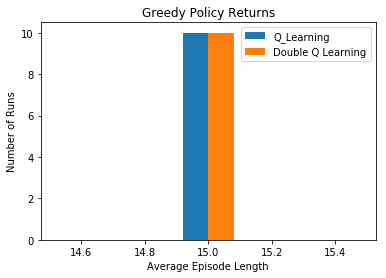

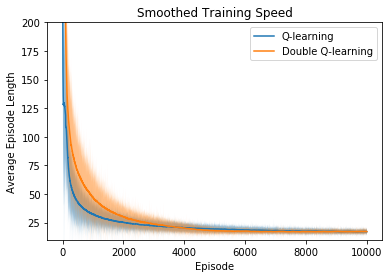

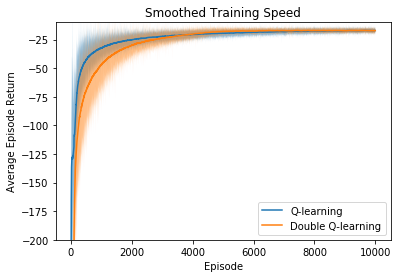

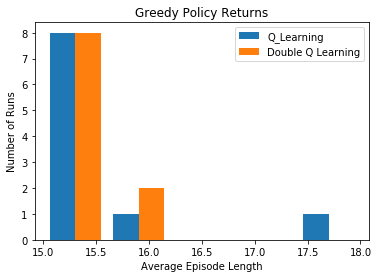

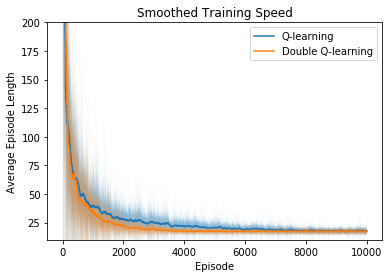

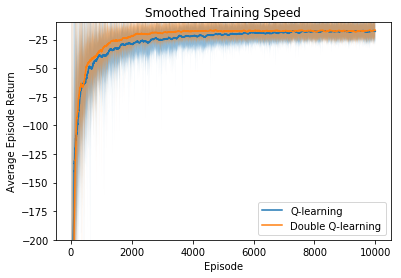

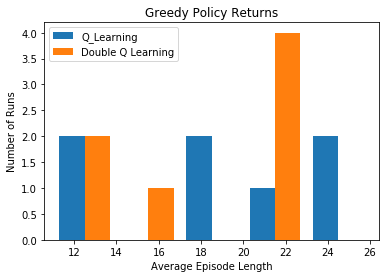

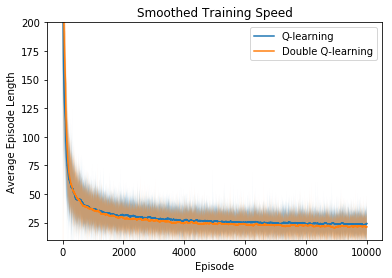

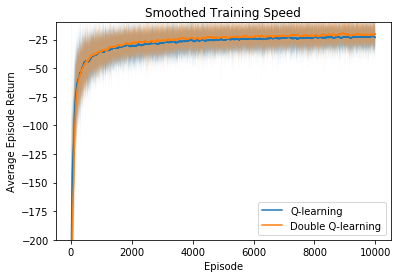

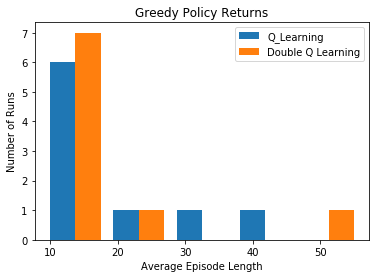

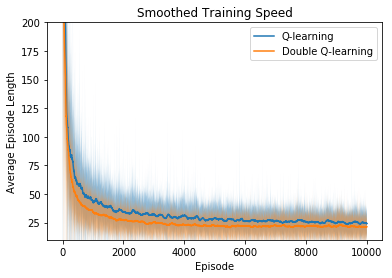

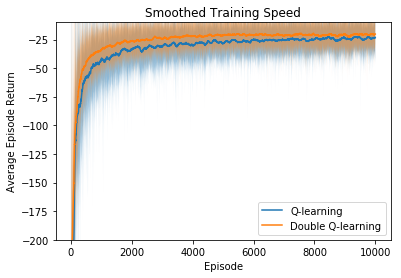

In [0]:
# YOUR CODE HERE

# Perform 30 training procedures until convergences for each under epsilon greedy, then sample one episode for each under a greedy policy.
# Note that one episode is sufficient as the environment dynamics are deterministic.
# In practice, 7 runs give greedy policies that get stuck in an infinite loop (moving down while the wind blows one tile up)
# Afterwards, we can compare both populations visually using a histogram and statistically using a t-test
# Note that we can apply a t-test due to the sufficient amount of runs giving us a normal sample mean by the CLT

# Note that since the average rewards of Q-learning is higher than SARSA and the t-test shows that difference is significant.
# We can finally conclude that Q-learning performs better than SARSA under a greedy policy for the windy gridworld env.
# 
# This is in line with our expectations


n_runs = 10
n_episodes = 10000
n_samples = 1000

n_average = 100

outfolder = os.path.join(os.getcwd(), 'out')
if not os.path.exists(outfolder):
  os.makedirs(outfolder)


for env, name in zip(envs, names): 

  f = open(os.path.join(outfolder, name + '.txt'), 'w+')
  if not os.path.isfile(os.path.join(outfolder, name + "_runs.pkl")):
    Qs, q_learning_lengths, q_learning_returns, d_Qs, double_q_learning_lengths, double_q_learning_returns = perform_learning(env, n_runs, n_episodes)
    with open(os.path.join(outfolder, name + "_runs.pkl"), 'wb') as pickle_file:
      dill.dump((Qs, q_learning_lengths, q_learning_returns, d_Qs, double_q_learning_lengths, double_q_learning_returns), pickle_file)
  else:
    with open(os.path.join(outfolder, name + "_runs.pkl"), 'rb') as pickle_file:
      Qs, q_learning_lengths, q_learning_returns, d_Qs, double_q_learning_lengths, double_q_learning_returns = dill.load(pickle_file)
    
  get_samples(env, Qs, d_Qs, n_samples, name, f)
  
  plot_smoothed(q_learning_lengths, double_q_learning_lengths, n_average, name, "Length", ylim=[10, 200])
  plot_smoothed(q_learning_returns, double_q_learning_returns, n_average, name, "Return", ylim=[-200, -10])
  
  f.close()

In [0]:
!zip -r /content/out.zip /content/out

  adding: content/out/ (stored 0%)
  adding: content/out/windy_gridworld_s_r_return_training.png (deflated 2%)
  adding: content/out/windy_gridworld_r.txt (deflated 43%)
  adding: content/out/windy_gridworld_r_return_training.png (deflated 2%)
  adding: content/out/windy_gridworld_r_runs.pkl (deflated 22%)
  adding: content/out/windy_gridworld_length_training.png (deflated 3%)
  adding: content/out/windy_gridworld_s_runs.pkl (deflated 71%)
  adding: content/out/windy_gridworld_s.txt (deflated 34%)
  adding: content/out/windy_gridworld.txt (deflated 47%)
  adding: content/out/windy_gridworld_return_training.png (deflated 3%)
  adding: content/out/windy_gridworld_r_length_training.png (deflated 2%)
  adding: content/out/windy_gridworld_s_return_training.png (deflated 2%)
  adding: content/out/windy_gridworld_s_r_runs.pkl (deflated 26%)
  adding: content/out/windy_gridworld_s_r_samples.png (deflated 11%)
  adding: content/out/windy_gridworld_samples.png (deflated 12%)
  adding: content/ou